In [1]:
"""
将结果绘制成曲线图
"""
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import heapq
import random
import os
from scipy.io import loadmat

# 读取数据
def get_data(city):
    with open('data_proces/'+ city +'data_heterHyper.pickle', 'rb') as file:
        data_social = pickle.load(file)

    friendship_new_df = data_social['friendship_new_df']
    friendship_old_df = data_social['friendship_old_df']
    deepwalk_S_id_vec_list = data_social['deepwalk_S_id_vec_list']
    num_u = len(deepwalk_S_id_vec_list) - 1

    # 为了方便GAT训练，这里把用户的id都-1，让id从0开始
    for ii in range(len(friendship_old_df)):
        friendship_old_df['uid1'][ii] -= 1
        friendship_old_df['uid2'][ii] -= 1
    for ii in range(len(friendship_new_df)):
        friendship_new_df['uid1'][ii] -= 1
        friendship_new_df['uid2'][ii] -= 1

    return friendship_new_df, friendship_old_df, num_u

# 计算LBSN时专用
def get_mat_dataset_friends(city):
    sources_directory = '/workspace/dataset/Foursquare/sources'
    city_mat_fp = os.path.join(sources_directory, 'dataset_connected_{city}.mat')
    mat_fp = city_mat_fp.format(city=city)
    mat_dict = loadmat(mat_fp)
    friendship_new_np = mat_dict['friendship_new']
    friendship_old_np = mat_dict['friendship_old']
    friendship_new_df = pd.DataFrame(friendship_new_np, columns=['uid1', 'uid2'])
    friendship_old_df = pd.DataFrame(friendship_old_np, columns=['uid1', 'uid2'])
    num_u = max(max(friendship_new_df['uid1']), max(friendship_new_df['uid2']), max(friendship_old_df['uid1']),
                max(friendship_old_df['uid2']))

    for ii in range(len(friendship_old_df)):
        friendship_old_df['uid1'][ii] -= 1
        friendship_old_df['uid2'][ii] -= 1
    for ii in range(len(friendship_new_df)):
        friendship_new_df['uid1'][ii] -= 1
        friendship_new_df['uid2'][ii] -= 1

    return friendship_new_df, friendship_old_df, num_u

# 读取LBSN2Vec的数据
def get_mat_dataset(emb_path, city):
    # 读LBSN2VEC
    city_mat_fp = os.path.join(emb_path + 'embs_{city}.mat')
    mat_fp = city_mat_fp.format(city=city)
    mat_dict = loadmat(mat_fp)
    embs_usr = mat_dict['embs_user']

    prob_adj = cosinematrix(torch.tensor(embs_usr))
    for ii in range(len(prob_adj)):
        prob_adj[ii][ii] = 0

    return prob_adj

# 计算余弦相似度
def cosinematrix(A):
    prod = torch.mm(A, A.t())  # 分子
    norm = torch.norm(A, p=2, dim=1).unsqueeze(0)  # 分母
    cos = prod.div(torch.mm(norm.t(), norm))
    return cos

# 计算count_o2n_Acc_Recall中需要的link_new_labels_M，目的是为了保证计算各方法的结果时负采样一致
def count_link_lables(num_user, friendship_new_df, friendship_old_df, neg_num):
    # 社交网络邻接矩阵 考虑id从1开始
    link_new_labels_M = np.zeros((num_user, num_user))
    for uid1, uid2 in zip(friendship_new_df['uid1'], friendship_new_df['uid2']):
        link_new_labels_M[uid1][uid2] = 1
        link_new_labels_M[uid2][uid1] = 1
    # 旧社交网络邻接矩阵
    for uid1, uid2 in zip(friendship_old_df['uid1'], friendship_old_df['uid2']):
        link_new_labels_M[uid1][uid2] = 2  # 原new的社交链接中实际上是old+新增的社交链接，所以这里将新增社交链接中的旧链接去掉，防止影响后面预测（特别是召回率分母）
        link_new_labels_M[uid2][uid1] = 2
    if neg_num == 0:
        return link_new_labels_M
    # 进行负采样，只让采样上的为3，其他为0
    for link_u_new_l in link_new_labels_M:
        tensor_link_u_new_l = torch.tensor(link_u_new_l)
        pre_ind = torch.eq(tensor_link_u_new_l, 0).nonzero().numpy().tolist()
        for preI in random.sample(pre_ind, neg_num):# 负样本随机抽取neg_num(50)个
            link_u_new_l[preI[0]] = 3
    return link_new_labels_M

# 提前计算好prob_adj每行排序后得到的index
def count_rank_prob_adj(prob_adj, link_new_labels_M, neg_num):
    prob_adj = prob_adj.cpu().detach().numpy()

    rank_index_prod = []
    for link_u_p, link_u_new_l in zip(prob_adj, link_new_labels_M):
        link_u_l = list(link_u_new_l)
        num_1 = link_u_l.count(1)  # 计算一下该用户应该有的链接数
        if num_1 == 0:  # 该用户没有新的社交链接 则跳过 不排序
            rank_index_prod.append([])
            continue
        if neg_num != 0: # 要抽负样本
            tensor_link_u_new_l = torch.tensor(link_u_new_l)
            pre_ind = torch.eq(tensor_link_u_new_l, 1).nonzero().numpy().tolist()
            for preI in pre_ind:
                link_u_p[preI[0]] += 1000  # 正样本全参与预测
            pre_ind = torch.eq(tensor_link_u_new_l, 3).nonzero().numpy().tolist()
            for preI in pre_ind:
                link_u_p[preI[0]] += 1000  # 抽取的负样本参与预测
        sort_enu = sorted(enumerate(link_u_p), key=lambda line: line[1], reverse=True)
        sort_index = [x[0] for x in sort_enu]  # 得到从大到小排序后的坐标
        rank_index_prod.append(sort_index)

    return rank_index_prod

# 计算accuracy，recall计算,考虑旧的社交链接问题
def count_o2n_Acc_Recall(K_list, rank_index_prod, link_new_labels_M):
    len_K_list = len(K_list)
    P_K_list = [[] for _ in range(len_K_list)]
    R_K_list = [[] for _ in range(len_K_list)]
    # 计算精确度和召回率

    # 在全局中进行预测
    for line_rank, link_u_new_l in zip(rank_index_prod, link_new_labels_M):
        link_u_l = list(link_u_new_l)
        num_1 = link_u_l.count(1)  # 计算一下该用户应该有的链接数
        if num_1 == 0:  # 该用户没有新的社交链接 则跳过
            continue

        tmpK = 0
        N_u_true = 0
        index_K = 0
        for index in line_rank:
            if link_u_new_l[index] == 2: #旧的社交链接不参与预测
                continue
            if link_u_new_l[index] == 1:
                N_u_true += 1
            tmpK += 1
            if tmpK == K_list[index_K]:
                P_K_list[index_K].append(N_u_true / K_list[index_K])
                R_K_list[index_K].append(N_u_true / num_1)
                index_K += 1
                if index_K == len(K_list):
                    break
    P_list = []
    R_list = []
    F1_list = []
    for ii in range(len_K_list):
        P_ = sum(P_K_list[ii]) / len(P_K_list[ii])
        R_ = sum(R_K_list[ii]) / len(R_K_list[ii])
        if P_ + R_ != 0:
            F1_ = 2 * (P_ * R_) / (P_ + R_)
        else:
            F1_ = 0
        P_list.append(P_)
        R_list.append(R_)
        F1_list.append(F1_)

    return P_list, R_list, F1_list

# 链接预测
def linkPrediction(neg_num, K_list, cities):
    # 计算所有的曲线数值
    result_city_PRF1_method_neg = {}
    method_list = "tmp"
    for city in cities:
        # 读取数据
        # 读取各种方法的prob_adj
        with open('data_proces/' + city + '_prob_adj.pickle', 'rb') as file:
            prob_adj_city = pickle.load(file)
        # 再读LBSN2Vec
        emb_path = "../LBSN2vec/result_embs_60epoch_10neg_10win_0001rate/"
        prob_adj = get_mat_dataset(emb_path, city)
        prob_adj_city['LBSN2Vec'] = prob_adj
        
        method_list = prob_adj_city.keys()
        # 开始计算
        result_city_PRF1_method_neg[city] = {'P@K': {}, 'R@K': {}, 'F1@K': {}}
        print("*" * 20, "开始处理" + city + "的数据", "*" * 20)
        # 读取数据
        friendship_new_df, friendship_old_df, num_u = get_data(city)
        link_new_labels_M = count_link_lables(num_u, friendship_new_df, friendship_old_df, neg_num)

        for method in method_list:
            if method == 'LBSN2Vec':
                friendship_new_df, friendship_old_df, num_u = get_mat_dataset_friends(city)
                link_new_labels_M = count_link_lables(num_u, friendship_new_df, friendship_old_df, neg_num)
            print("-" * 10, "计算" + city + " " + method + " " + "-" * 10)
            rank_index_prod = count_rank_prob_adj(prob_adj_city[method], link_new_labels_M, neg_num)
            result_city_PRF1_method_neg[city]['P@K'][method] = []
            result_city_PRF1_method_neg[city]['R@K'][method] = []
            result_city_PRF1_method_neg[city]['F1@K'][method] = []

            P_list, R_list, F1_list = count_o2n_Acc_Recall(K_list, rank_index_prod, link_new_labels_M)
            for i_k in range(len(K_list)):
                result_city_PRF1_method_neg[city]['P@K'][method].append(P_list[i_k])
                result_city_PRF1_method_neg[city]['R@K'][method].append(R_list[i_k])
                result_city_PRF1_method_neg[city]['F1@K'][method].append(F1_list[i_k])
    return method_list, result_city_PRF1_method_neg

def drawPic(method_list, result_city_PRF1_method_neg, cities, K_list, pic_name):
    # 绘制曲线
    line_color = ['red', 'grey', 'chocolate', 'green', 'blue', 'purple', 'pink', 'yellow', 'black', 'cyan', 'magenta']
    lint_mark = [ 'o', '*', '<', '1', '2', '3', '4', ',', '^', '>', 'p']
    index_x = [i + 1 for i in range(len(K_list))]
    row_list = ['P@K', 'R@K', 'F1@K']
    col_list = cities
    row = len(row_list)
    col = len(col_list)
    fig, axes = plt.subplots(row, col, figsize=(18, 8))
    for tmp_row in range(row):
        for tmp_col in range(col):
            tmp_city = col_list[tmp_col]
            tmp_PRF1 = row_list[tmp_row]
            count = 0
            for method in method_list:
                # 绘制曲线
                axes[tmp_row, tmp_col].plot(index_x, result_city_PRF1_method_neg[tmp_city][tmp_PRF1][method],
                                            color=line_color[count], linewidth=1.0, label=method,
                                            marker=lint_mark[count])
                axes[tmp_row, tmp_col].set_xticks(index_x, [str(kk) for kk in K_list])
                # 添加样式
                axes[tmp_row, tmp_col].set_title(tmp_city, fontdict={"fontsize": 15})  # 标题
                axes[tmp_row, tmp_col].set_xlabel('K')  # 添加横轴标签
                axes[tmp_row, tmp_col].set_ylabel(tmp_PRF1)  # 添加纵轴标签
                axes[tmp_row, tmp_col].grid(True)
                count += 1
    fig.legend(method_list, loc='upper center', ncol=len(method_list), bbox_to_anchor=(0.5, 1.05),
               fontsize=15)  # 绘制前len(methods)个图例
    plt.tight_layout()
    plt.savefig('result_pic/' + pic_name + '_result.jpg', dpi=200, bbox_inches='tight')
    plt.show()

# 全局预测

In [11]:
# cities = ["Istanbul", "Jakarta", "KualaLampur", "NYC", "SaoPaulo", "TKY"]
cities = ["NYC", "SaoPaulo"]

# 全局预测
neg_num = 0
K_list = [10, 20, 50, 100, 200]
method_list, result_city_PRF1_method_all = linkPrediction(neg_num, K_list, cities)

******************** 开始处理NYC的数据 ********************
---------- 计算NYC deepwalk_S ----------
---------- 计算NYC node2vec_S ----------
---------- 计算NYC LINE_S ----------
---------- 计算NYC HeterHyperWalk ----------
---------- 计算NYC SHGAE ----------
---------- 计算NYC SHGAE_Ablation3 ----------
---------- 计算NYC SHGAE_Ablation1 ----------
---------- 计算NYC SHGAE_Ablation2 ----------
---------- 计算NYC LBSN2Vec ----------
******************** 开始处理SaoPaulo的数据 ********************
---------- 计算SaoPaulo deepwalk_S ----------
---------- 计算SaoPaulo node2vec_S ----------
---------- 计算SaoPaulo LINE_S ----------
---------- 计算SaoPaulo HeterHyperWalk ----------
---------- 计算SaoPaulo SHGAE ----------
---------- 计算SaoPaulo SHGAE_Ablation3 ----------
---------- 计算SaoPaulo SHGAE_Ablation1 ----------
---------- 计算SaoPaulo SHGAE_Ablation2 ----------
---------- 计算SaoPaulo LBSN2Vec ----------


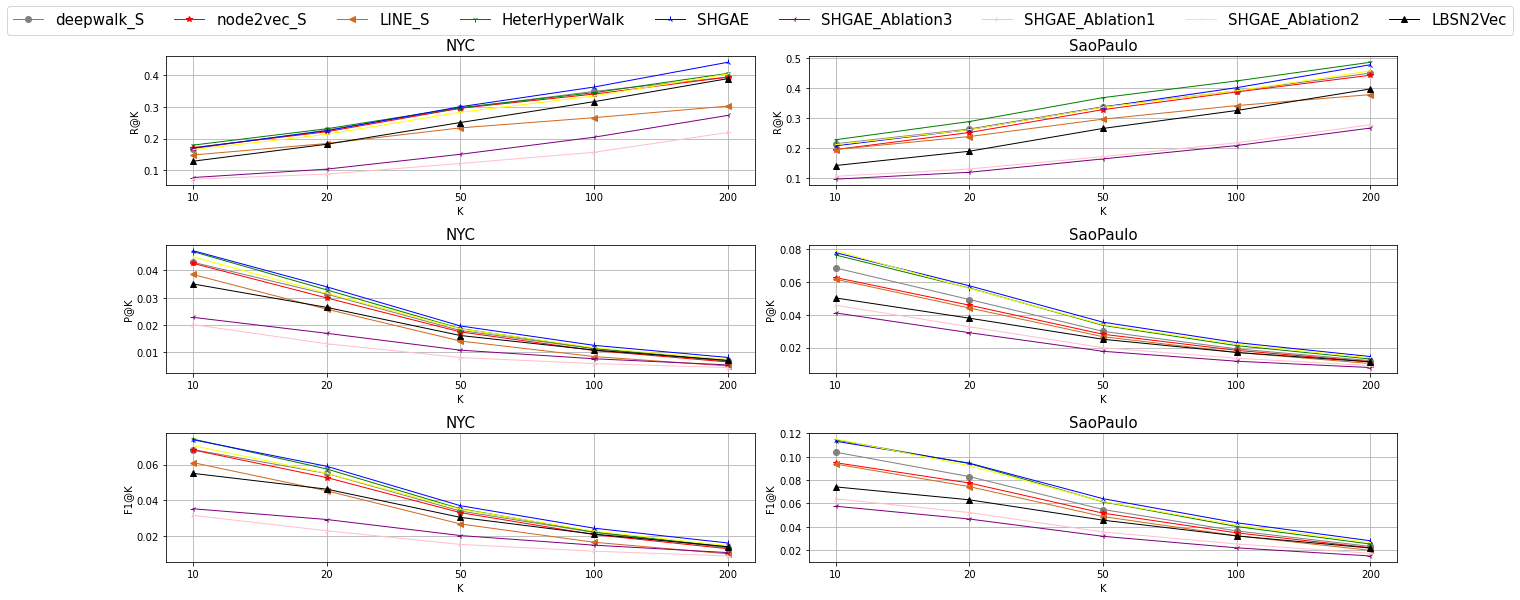

In [12]:
# method_list = ['deepWalk', 'HeterHyperWalk', 'Best_HeterHyperWalk', 'HyperHeterWalk+GAT', 'LBSN2Vec']
drawPic(method_list, result_city_PRF1_method_all, cities, K_list, '全局预测')

# 抽负样本预测（抽负样本50，K：10,20,30,40,50）

In [2]:
cities = ["NYC", "TKY", "Istanbul", "Jakarta", "KualaLampur",  "SaoPaulo"]
# cities = ["NYC", "SaoPaulo"]
# 抽样预测
neg_num = 50
K_list = [8, 10, 12, 14, 16]
method_list, result_city_PRF1_method_neg = linkPrediction(neg_num, K_list, cities)

******************** 开始处理Istanbul的数据 ********************
---------- 计算Istanbul deepwalk_S ----------
---------- 计算Istanbul node2vec_S ----------
---------- 计算Istanbul LINE_S ----------
---------- 计算Istanbul HeterHyperWalk ----------
---------- 计算Istanbul SHGAE ----------
---------- 计算Istanbul SHGAE_Ablation3 ----------
---------- 计算Istanbul SHGAE_Ablation1 ----------
---------- 计算Istanbul SHGAE_Ablation2 ----------
---------- 计算Istanbul LBSN2Vec ----------
******************** 开始处理Jakarta的数据 ********************
---------- 计算Jakarta deepwalk_S ----------
---------- 计算Jakarta node2vec_S ----------
---------- 计算Jakarta LINE_S ----------
---------- 计算Jakarta HeterHyperWalk ----------
---------- 计算Jakarta SHGAE ----------
---------- 计算Jakarta SHGAE_Ablation3 ----------
---------- 计算Jakarta SHGAE_Ablation1 ----------
---------- 计算Jakarta SHGAE_Ablation2 ----------
---------- 计算Jakarta LBSN2Vec ----------
******************** 开始处理KualaLampur的数据 ********************
---------- 计算KualaLampur 

In [5]:
method_list

dict_keys(['deepwalk_S', 'node2vec_S', 'LINE_S', 'HeterHyperWalk', 'SHGAE', 'SHGAE_Ablation3', 'SHGAE_Ablation1', 'SHGAE_Ablation2', 'LBSN2Vec'])

In [6]:
cities = ["NYC", "TKY", "Istanbul", "Jakarta", "KualaLampur",  "SaoPaulo"]

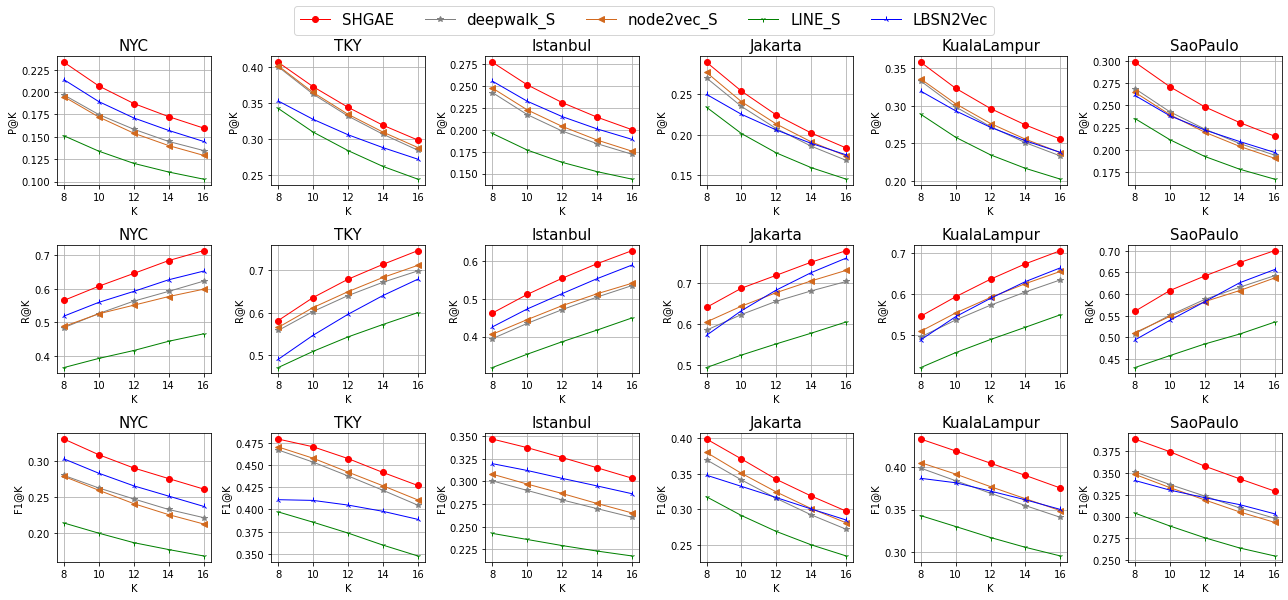

In [7]:
method_list = ['SHGAE', 'deepwalk_S', 'node2vec_S', 'LINE_S', 'LBSN2Vec']
drawPic(method_list, result_city_PRF1_method_neg, cities, K_list, '抽样50预测64')

In [40]:
# method_list =['SHGAE', 'SHGAE_Ablation1', 'SHGAE_Ablation2', 'SHGAE_Ablation3', 'HeterHyperWalk',]
# drawPic(method_list, result_city_PRF1_method_neg, cities, K_list, '抽样50预测_消融')

# 输出消融实验需要的数据 latex格式

In [8]:
cities = ["NYC", "TKY", "Istanbul", "Jakarta", "KualaLampur",  "SaoPaulo"]
method_list =['SHGAE_Ablation1', 'SHGAE_Ablation2', 'SHGAE_Ablation3', 'HeterHyperWalk', 'SHGAE']
method_list2 = ['SHGAE-A1', 'SHGAE-A2', 'SHGAE-A3', 'SHGAE-A4', 'SHGAE']

str_city = ''
str_PR = ''
for city in cities:
    str_city += '&' + "\\multicolumn{2}{c}{" + city + "}"
    str_PR += "& P@K & R@K"
print(str_city)
print(str_PR)

for method_i in range(len(method_list)):
    if method_i == len(method_list) - 1:
        method = method_list[method_i]
        print_str = method_list2[method_i] 
        for city in cities:
            print_str = print_str + "&" + "\\textbf{" + str(round(result_city_PRF1_method_neg[city]['P@K'][method][1],3)) + "}"
            print_str = print_str + "&" + "\\textbf{" + str(round(result_city_PRF1_method_neg[city]['R@K'][method][1],3)) + "}"
            # print_str = print_str + "&" + str(round(result_city_PRF1_method_neg[city]['F1@K'][method][1],3)) 
            if city == cities[-1]:
                print_str += "\\\\"
        print(print_str)
    else:
        method = method_list[method_i]
        print_str = method_list2[method_i]
        for city in cities:
            print_str = print_str + "&" + str(round(result_city_PRF1_method_neg[city]['P@K'][method][1],3)) 
            print_str = print_str + "&" + str(round(result_city_PRF1_method_neg[city]['R@K'][method][1],3)) 
            # print_str = print_str + "&" + str(round(result_city_PRF1_method_neg[city]['F1@K'][method][1],3)) 
            if city == cities[-1]:
                print_str += "\\\\"
        print(print_str)

&\multicolumn{2}{c}{NYC}&\multicolumn{2}{c}{TKY}&\multicolumn{2}{c}{Istanbul}&\multicolumn{2}{c}{Jakarta}&\multicolumn{2}{c}{KualaLampur}&\multicolumn{2}{c}{SaoPaulo}
& P@K & R@K& P@K & R@K& P@K & R@K& P@K & R@K& P@K & R@K& P@K & R@K
SHGAE-A1&0.147&0.414&0.241&0.379&0.158&0.309&0.169&0.43&0.211&0.356&0.206&0.416\\
SHGAE-A2&0.198&0.584&0.366&0.619&0.237&0.471&0.246&0.652&0.312&0.562&0.261&0.577\\
SHGAE-A3&0.168&0.488&0.22&0.347&0.195&0.412&0.212&0.563&0.239&0.438&0.196&0.43\\
SHGAE-A4&0.187&0.553&0.376&0.627&0.255&0.517&0.252&0.676&0.32&0.579&0.259&0.59\\
SHGAE&\textbf{0.207}&\textbf{0.607}&\textbf{0.373}&\textbf{0.636}&\textbf{0.251}&\textbf{0.511}&\textbf{0.254}&\textbf{0.688}&\textbf{0.324}&\textbf{0.594}&\textbf{0.271}&\textbf{0.608}\\
